In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.cm import get_cmap
import numpy as np
import geopandas as gpd
import seaborn as sns
from geopandas.tools import sjoin
import contextily as ctx
from shapely import wkt

In [2]:
london_devices_loc = 'datasets/user_devices/london_user_device.csv'
birmingham_devices_loc = 'datasets/user_devices/birmingham_user_device.csv'
liverpool_devices_loc = 'datasets/user_devices/liverpool_user_device.csv'

london_homeantenna_loc = 'datasets/012020/home_ldn_onlysmartphones.csv'
birmingham_homeantenna_loc = 'datasets/012020/home_birm_onlysmartphones.csv'
liverpool_homeantenna_loc = 'datasets/012020/home_lpool_onlysmartphones.csv'

london_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_london_imd_pd.csv'
birmingham_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_birmingham_imd_pd.csv'
liverpool_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_liverpool_imd_pd.csv'

MMYYYY_list = ['042019', '072019', '102019', '012020']
london_userperf_loc = ['datasets/042019/userperf_ldn_2019_04.csv', 
                       'datasets/072019/userperf_ldn_2019_07.csv', 
                       'datasets/102019/userperf_ldn_2019_10.csv',
                       'datasets/012020/userperf_ldn_2020_jan.csv']
birmingham_userperf_loc = ['datasets/042019/userperf_birm_2019_04.csv', 
                           'datasets/072019/userperf_birm_2019_07.csv', 
                           'datasets/102019/userperf_birm_2019_10.csv',
                           'datasets/012020/userperf_birm_2020_jan.csv']
liverpool_userperf_loc = ['datasets/042019/userperf_lpool_2019_04.csv', 
                          'datasets/072019/userperf_lpool_2019_07.csv', 
                          'datasets/102019/userperf_lpool_2019_10.csv', 
                          'datasets/012020/userperf_lpool_2020_jan.csv']

# Preprocessing : filter Smartphones
Sections of code taken from UK_Devices.ipynb

In [3]:
london_devices_pd = pd.read_csv(london_devices_loc, index_col=False).rename(columns={'decile': 'IMDDecil'})
birmingham_devices_pd = pd.read_csv(birmingham_devices_loc, index_col=False).rename(columns={'decile': 'IMDDecil'})
liverpool_devices_pd = pd.read_csv(liverpool_devices_loc, index_col=False).rename(columns={'decile': 'IMDDecil'})

london_devices_pd.fillna('NA', inplace=True)
birmingham_devices_pd.fillna('NA', inplace=True)
liverpool_devices_pd.fillna('NA', inplace=True)

# define data we will filter from userperf datasets(to make it easier to understand in merge()) - for simplicity only filter data, do not add any additional information
london_devices_pd_2merge = london_devices_pd[london_devices_pd.tacDeviceType=='smartphone'][['device_id']]
birmingham_devices_pd_2merge = birmingham_devices_pd[birmingham_devices_pd.tacDeviceType=='smartphone'][['device_id']]
liverpool_devices_pd_2merge = liverpool_devices_pd[liverpool_devices_pd.tacDeviceType=='smartphone'][['device_id']] 

In [21]:
london_userperf_pd = pd.read_csv(london_userperf_loc[0], index_col=False)
london_userperf_pd['MMYYYY'] = MMYYYY_list[0]
for loc,dt in zip(london_userperf_loc[1:], MMYYYY_list[1:]):
    temp = pd.read_csv(loc, index_col=False)
    temp['MMYYYY'] = dt
    london_userperf_pd = london_userperf_pd.append(temp, ignore_index=True)

birmingham_userperf_pd = pd.read_csv(birmingham_userperf_loc[0], index_col=False)
birmingham_userperf_pd['MMYYYY'] = MMYYYY_list[0]
for loc,dt in zip(birmingham_userperf_loc[1:], MMYYYY_list[1:]):
    temp = pd.read_csv(loc, index_col=False)
    temp['MMYYYY'] = dt
    birmingham_userperf_pd = birmingham_userperf_pd.append(temp, ignore_index=True)

liverpool_userperf_pd = pd.read_csv(liverpool_userperf_loc[0], index_col=False)
liverpool_userperf_pd['MMYYYY'] = MMYYYY_list[0]
for loc,dt in zip(liverpool_userperf_loc[1:], MMYYYY_list[1:]):
    temp = pd.read_csv(loc, index_col=False)
    temp['MMYYYY'] = dt
    liverpool_userperf_pd = liverpool_userperf_pd.append(temp, ignore_index=True)


london_userperf_pd = pd.merge(london_userperf_pd, london_devices_pd_2merge, on='device_id', how='inner')
birmingham_userperf_pd = pd.merge(birmingham_userperf_pd, birmingham_devices_pd_2merge, on='device_id', how='inner')
liverpool_userperf_pd = pd.merge(liverpool_userperf_pd, liverpool_devices_pd_2merge, on='device_id', how='inner')

# Avg. 4G packet retran. frequency of TCP sessions and Avg. 4G latency
Sections of code take from UK_Diagrams_IMC2020.ipynb

In [22]:
london_homeantenna_pd = pd.read_csv(london_homeantenna_loc, index_col=False)
birmingham_homeantenna_pd = pd.read_csv(birmingham_homeantenna_loc, index_col=False)
liverpool_homeantenna_pd = pd.read_csv(liverpool_homeantenna_loc, index_col=False)

london_antenna_imd_pd = pd.read_csv(london_antenna_imd_loc, index_col=False)
birmingham_antenna_imd_pd = pd.read_csv(birmingham_antenna_imd_loc, index_col=False)
liverpool_antenna_imd_pd = pd.read_csv(liverpool_antenna_imd_loc, index_col=False)

london_userperf_pd = pd.merge(london_userperf_pd, london_homeantenna_pd, on='device_id', how='inner')
london_userperf_pd = pd.merge(london_userperf_pd, london_antenna_imd_pd, left_on='antenna_id', right_on='lkey', how='inner')

birmingham_userperf_pd = pd.merge(birmingham_userperf_pd, birmingham_homeantenna_pd, on='device_id', how='inner')
birmingham_userperf_pd = pd.merge(birmingham_userperf_pd, birmingham_antenna_imd_pd, left_on='antenna_id', right_on='lkey', how='inner')

liverpool_userperf_pd = pd.merge(liverpool_userperf_pd, liverpool_homeantenna_pd, on='device_id', how='inner')
liverpool_userperf_pd = pd.merge(liverpool_userperf_pd, liverpool_antenna_imd_pd, left_on='antenna_id', right_on='lkey', how='inner')

In [23]:
for column in ['avg(rtt4g_avg)', 'avg(retx4g_avg)']:
    for dt in MMYYYY_list:
        london_userperf_pd.loc[london_userperf_pd['MMYYYY']==dt, column] = london_userperf_pd.loc[london_userperf_pd['MMYYYY']==dt, column]/london_userperf_pd.loc[london_userperf_pd['MMYYYY']==dt, column].max()
        birmingham_userperf_pd.loc[birmingham_userperf_pd['MMYYYY']==dt, column] = birmingham_userperf_pd.loc[birmingham_userperf_pd['MMYYYY']==dt, column]/birmingham_userperf_pd.loc[birmingham_userperf_pd['MMYYYY']==dt, column].max()
        liverpool_userperf_pd.loc[liverpool_userperf_pd['MMYYYY']==dt, column] = liverpool_userperf_pd.loc[liverpool_userperf_pd['MMYYYY']==dt, column]/liverpool_userperf_pd.loc[liverpool_userperf_pd['MMYYYY']==dt, column].max()

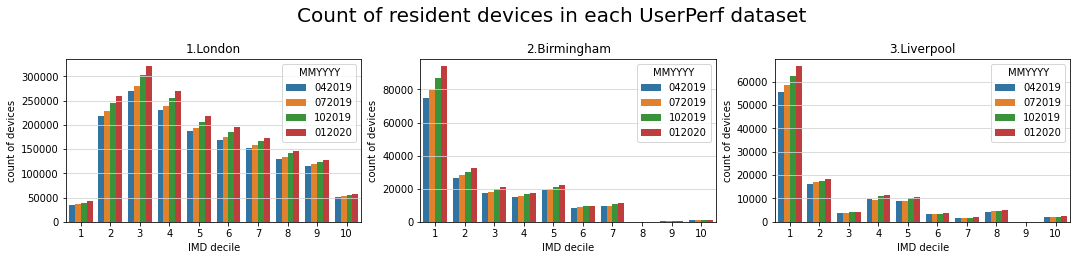

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(18, 3), facecolor='w', edgecolor='k')
fig.suptitle('Count of resident devices in each UserPerf dataset', size=20, y=1.12)
def applyPlotStyle(ax):
    ax.yaxis.grid(True, linestyle='-', which='both', color='lightgrey')
    #ax.set_ylim([0,0.035])
    ax.set_xlabel('IMD decile')
    ax.set_ylabel('count of devices')

london = sns.countplot(ax = ax[0], x='IMDDecil', hue='MMYYYY', data=london_userperf_pd, hue_order=MMYYYY_list)
applyPlotStyle(ax[0])
ax[0].set_title('1.London')

birmingham = sns.countplot(ax=ax[1], x='IMDDecil', hue='MMYYYY', data=birmingham_userperf_pd, hue_order=MMYYYY_list)
applyPlotStyle(ax[1])
ax[1].set_title('2.Birmingham')

liverpool = sns.countplot(ax=ax[2], x='IMDDecil', hue='MMYYYY', data=liverpool_userperf_pd, hue_order=MMYYYY_list)
applyPlotStyle(ax[2])
ax[2].set_title('3.Liverpool');

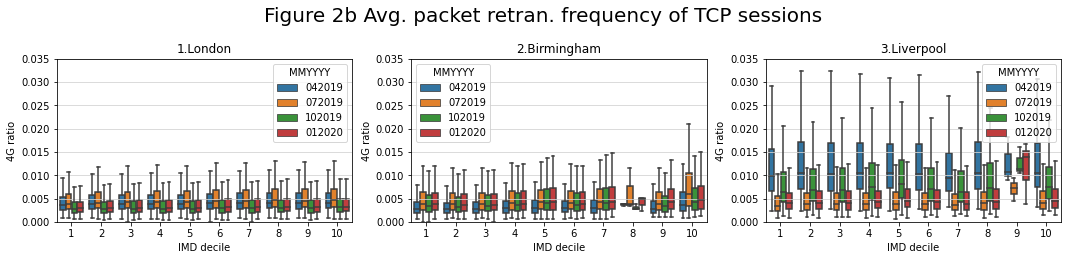

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(18, 3), facecolor='w', edgecolor='k')
fig.suptitle('Figure 2b Avg. packet retran. frequency of TCP sessions', size=20, y=1.12)
def applyPlotStyle(ax):
    ax.yaxis.grid(True, linestyle='-', which='both', color='lightgrey')
    ax.set_ylim([0,0.035])
    ax.set_xlabel('IMD decile')
    ax.set_ylabel('4G ratio')

#london = sns.violinplot(ax = ax[0], x='IMDDecil', y='avg(rtt4g_avg)', hue='MMYYYY',scale='area', data=london_userperf_pd, split=True, showfliers=False)
london = sns.boxplot(ax = ax[0], x='IMDDecil', y='avg(rtt4g_avg)', hue='MMYYYY', data=london_userperf_pd, showfliers=False, hue_order=MMYYYY_list)
applyPlotStyle(ax[0])
ax[0].set_title('1.London')

#birmingham = sns.violinplot(ax=ax[1], x='IMDDecil', y='avg(rtt4g_avg)', hue='MMYYYY',scale='area', data=birmingham_userperf_pd, split=True, showfliers=False)
birmingham = sns.boxplot(ax=ax[1], x='IMDDecil', y='avg(rtt4g_avg)', hue='MMYYYY', data=birmingham_userperf_pd, showfliers=False, hue_order=MMYYYY_list)
applyPlotStyle(ax[1])
ax[1].set_title('2.Birmingham')

#liverpool = sns.violinplot(ax=ax[2], x='IMDDecil', y='avg(rtt4g_avg)', hue='MMYYYY',scale='area', data=liverpool_userperf_pd, split=True, showfliers=False)
liverpool = sns.boxplot(ax=ax[2], x='IMDDecil', y='avg(rtt4g_avg)', hue='MMYYYY', data=liverpool_userperf_pd, showfliers=False, hue_order=MMYYYY_list)
applyPlotStyle(ax[2])
ax[2].set_title('3.Liverpool');

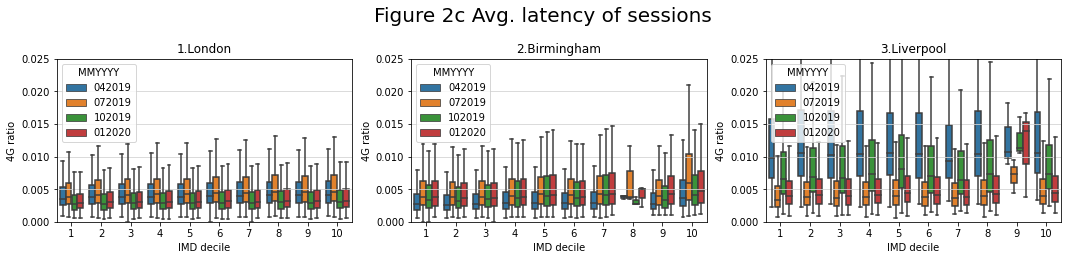

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(18, 3), facecolor='w', edgecolor='k')
fig.suptitle('Figure 2c Avg. latency of sessions', size=20, y=1.12)
def applyPlotStyle(ax):
    ax.yaxis.grid(True, linestyle='-', which='both', color='lightgrey')
    ax.set_ylim([0,0.025])
    ax.set_xlabel('IMD decile')
    ax.set_ylabel('4G ratio')

#london = sns.violinplot(ax = ax[0], x='IMDDecil', y='avg(rtt4g_avg)', hue='MMYYYY',scale='area', data=london_userperf_pd, split=True, showfliers=False)
london = sns.boxplot(ax = ax[0], x='IMDDecil', y='avg(rtt4g_avg)', hue='MMYYYY', data=london_userperf_pd, showfliers=False, hue_order=MMYYYY_list)
applyPlotStyle(ax[0])
ax[0].set_title('1.London')

#birmingham = sns.violinplot(ax=ax[1], x='IMDDecil', y='avg(rtt4g_avg)', hue='MMYYYY',scale='area', data=birmingham_userperf_pd, split=True, showfliers=False)
birmingham = sns.boxplot(ax=ax[1], x='IMDDecil', y='avg(rtt4g_avg)', hue='MMYYYY', data=birmingham_userperf_pd, showfliers=False, hue_order=MMYYYY_list)
applyPlotStyle(ax[1])
ax[1].set_title('2.Birmingham')

#liverpool = sns.violinplot(ax=ax[2], x='IMDDecil', y='avg(rtt4g_avg)', hue='MMYYYY',scale='area', data=liverpool_userperf_pd, split=True, showfliers=False)
liverpool = sns.boxplot(ax=ax[2], x='IMDDecil', y='avg(rtt4g_avg)', hue='MMYYYY', data=liverpool_userperf_pd, showfliers=False, hue_order=MMYYYY_list)
applyPlotStyle(ax[2])
ax[2].set_title('3.Liverpool');